In [4]:
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

%matplotlib inline
  
import os

In [8]:
print(os.getcwd())

C:\Users\SouravKumar


In [23]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

In [27]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]], dtype=uint8)}

In [28]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


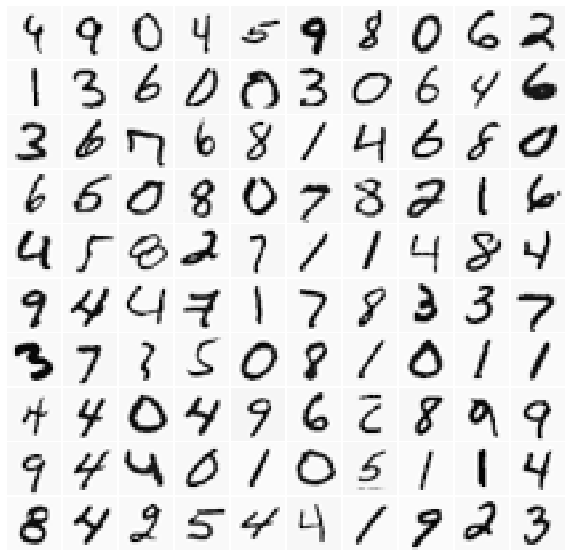

In [30]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [74]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

In [107]:
X_t

array([[1. , 0.1, 0.6, 1.1],
       [1. , 0.2, 0.7, 1.2],
       [1. , 0.3, 0.8, 1.3],
       [1. , 0.4, 0.9, 1.4],
       [1. , 0.5, 1. , 1.5]])

In [109]:
theta_t

array([ 0., -1.,  1.,  2.])

In [34]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [150]:
#regularized Cost Function
def lrCostFunction(theta, X, y, lambda_):
   
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # ====================== YOUR CODE HERE ======================
    temp=np.dot(X,theta)
    z=sigmoid(temp)
    J=(1/m)*sum(((-y)*np.log(z))-((1-y)*np.log(1-z)))
    temp2=z-y;
    grad+=(1/m)*sum(np.dot(X.T,temp2)) #unregularized
    temp3=theta
    temp[0]=0 # because we don't add anything for j = 0
    grad+= (lambda_/m)*temp3
    J+= (lambda_/(2*m))*sum(temp3*temp3)
    # =============================================================
    return J, grad

In [197]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 3.085728
Expected cost: 2.534819
-----------------------
Gradients:
 [1.213314, 0.613314, 1.813314, 2.413314]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


In [223]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Instructions
    ------------
    You should complete the following code to train `num_labels`
    logistic regression classifiers with regularization parameter `lambda_`. 
    
    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.
    
    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop 
    (`for c in range(num_labels):`) to loop over the different classes.
    
    Example Code
    ------------
    
        # Set Initial theta
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
    """
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
        all_theta[c]=res.x
    

    # ============================================================
    return all_theta

In [224]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

In [225]:
all_theta

array([[-0.03323786, -0.03323786, -0.03323786, ..., -0.03323786,
        -0.03323786, -0.03323786],
       [-0.05105345, -0.05105345, -0.05105345, ..., -0.05105345,
        -0.05105345, -0.05105345],
       [-0.03707986, -0.03707986, -0.03707986, ..., -0.03707986,
        -0.03707986, -0.03707986],
       ...,
       [-0.04250139, -0.04250139, -0.04250139, ..., -0.04250139,
        -0.04250139, -0.04250139],
       [-0.03686939, -0.03686939, -0.03686939, ..., -0.03686939,
        -0.03686939, -0.03686939],
       [-0.0412437 , -0.0412437 , -0.0412437 , ..., -0.0412437 ,
        -0.0412437 , -0.0412437 ]])

In [226]:
x=X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [232]:
np.dot(X[3345,:],all_theta.T)

array([-1.7668063 , -2.71381985, -1.97103362, -2.00899263, -2.21046498,
       -2.14502627, -2.0772264 , -2.25922269, -1.95984535, -2.19236823])

In [219]:
y[3345]

6

In [212]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index 
    of the max for each row.
    """
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    temp=np.dot(X,all_theta.T)
    p=np.argmax(temp,axis=1)
    # ============================================================
    return p

In [214]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 10.00%


In [215]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)